## DATASET: BREAST CANCER

Ung thư vú là một trong những bệnh ung thư phổ biến và nguy hiểm đối với phụ nữ. Việc phát hiện sớm ung thư vú đóng vai trò quan trọng trong việc nâng cao tỷ lệ sống sót và hiệu quả điều trị. Bộ dữ liệu "Breast Cancer" chứa các thông tin mô tả về các khối u vú, giúp phân loại khối u ác tính và lành tính. Trong nghiên cứu này, thuật toán Decision Tree được áp dụng để phân loại các khối u, qua đó hỗ trợ chẩn đoán ung thư vú một cách chính xác và nhanh chóng.

---

## Import

In [1]:
# Import các thư viện xử lý dữ liệu
import numpy as np
import pandas as pd

# Import các thư viện từ Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.datasets import load_breast_cancer
from ucimlrepo import fetch_ucirepo

# Import các thư viện đồ họa
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os
import logging

# Import các thư viện khác
import joblib
import graphviz
from graphviz import Source
from IPython.display import display

---

# I. UCI Breast Cancer Wisconsin (Diagnostic) Dataset

## 1. Preparing the Datasets

In [2]:
def load_data():
    # Fetch and extract dataset details
    data = fetch_ucirepo(id=17).data
    features, labels, feature_names = data.features, data.targets, data.feature_names

    # Shuffle the dataset
    features, labels = shuffle(features, labels, random_state=42)

    return features, labels, feature_names

In [3]:
def split_data(features, labels, train_size, test_size):
    return train_test_split(
        features, labels, 
        train_size=train_size, 
        test_size=test_size, 
        stratify=labels, 
        random_state=42
    )

In [4]:
def create_datasets(features, labels, split_ratios):
    return [split_data(features, labels, train_size, test_size) for train_size, test_size in split_ratios]

### 1.1 Create Training and Test Sets with Different Proportions

**Gọi hàm và khám phá dữ liệu**

In [5]:
features_shuffle, labels_shuffle, features_name = load_data()

In [6]:
print(features_shuffle.shape)
print(labels_shuffle.shape)

(569, 30)
(569, 1)


In [ ]:
features_shuffle.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


In [ ]:
labels_shuffle.head()

,Diagnosis
204,B
70,M
131,M
431,B
540,B


In [9]:
print(features_name)

None


**Ta sẽ chia tập dữ liệu theo các tỷ lệ sau: 40/60, 60/40, 80/20, and 90/10 (train/test)**

In [10]:
features_data = features_shuffle.values
labels_data = labels_shuffle.values

# Tạo data set theo các tỷ lệ khác nhau:
split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
datasets = create_datasets(features_data, labels_data, split_ratios)

### 1.2 Visualize Class Distributions

In [11]:
def visualize_distribution(datasets, proportions, labels, show_percentage=False, title="Dữ liệu phân phối", custom_colors=None):
    labels = labels.flatten() if labels.ndim > 1 else labels
    unique_labels = np.unique(labels)
    original_counts = pd.Series(labels).value_counts().reindex(unique_labels, fill_value=0).values

    colors = custom_colors or px.colors.qualitative.Plotly
    bar_width = 0.25

    for i, (train_size, test_size) in enumerate(proportions):
        _, _, train_labels, test_labels = datasets[i]
        train_labels = train_labels.flatten() if train_labels.ndim > 1 else train_labels
        test_labels = test_labels.flatten() if test_labels.ndim > 1 else test_labels

        train_counts = pd.Series(train_labels).value_counts().reindex(unique_labels, fill_value=0).values
        test_counts = pd.Series(test_labels).value_counts().reindex(unique_labels, fill_value=0).values

        if show_percentage:
            total_labels = len(labels)
            train_counts, test_counts, original_counts = train_counts / len(train_labels) * 100, test_counts / len(test_labels) * 100, original_counts / total_labels * 100

        x_positions = np.arange(len(unique_labels))

        fig = go.Figure()
        fig.add_trace(go.Bar(x=x_positions - bar_width, y=original_counts, name="Original Set", marker_color=colors[3], width=bar_width))
        fig.add_trace(go.Bar(x=x_positions, y=train_counts, name="Training Set", marker_color=colors[4], width=bar_width))
        fig.add_trace(go.Bar(x=x_positions + bar_width, y=test_counts, name="Testing Set", marker_color=colors[5], width=bar_width))

        fig.update_layout(
            title=f"{title} - Proportion {train_size}:{test_size}",
            xaxis=dict(title="Class", tickvals=x_positions, ticktext=unique_labels),
            yaxis=dict(title="Percentage" if show_percentage else "Count"),
            barmode="group", legend_title_text="Dataset"
        )
        fig.show()

# Gọi hàm
visualize_distribution(datasets, split_ratios, labels_data)

## 2. Building the Decision Tree Classifiers

### 2.1 Train Decision Tree Classifiers

In [12]:
def building_the_decision_tree(datasets, split_ratios, random_state=42, save_dir="Dataset 1/models/model_decision_tree"):
    logging.info("Starting model training...")
    os.makedirs(save_dir, exist_ok=True)
    list_models = []

    for (feature_train, _, label_train, _), (train_size, test_size) in zip(datasets, split_ratios):
        ratio = f"{int(train_size*100)}_{int(test_size*100)}"
        model = DecisionTreeClassifier(criterion="entropy", random_state=random_state)
        model.fit(feature_train, label_train)
        list_models.append(model)

        model_filename = os.path.join(save_dir, f"model_decision_tree_{ratio}.pkl")
        joblib.dump(model, model_filename)
        logging.info(f"Model saved: {model_filename}")

    return list_models

# Gọi hàm
list_models = building_the_decision_tree(datasets, split_ratios)

### 2.2 Visualize the Resulting Decision Tree with Graphviz


(process:17060): Pango-CRITICAL **: 18:49:20.649: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:17060): Pango-CRITICAL **: 18:49:20.649: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:17060): Pango-CRITICAL **: 18:49:20.650: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:17060): Pango-CRITICAL **: 18:49:20.650: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7520): Pango-CRITICAL **: 18:49:21.995: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7520): Pango-CRITICAL **: 18:49:21.995: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7520): Pango-CRITICAL **: 18:49:21.995: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7520): Pango-CRITICAL **: 18:49:21.996: pango_font_description_get_family: assertion 'desc != NULL' failed


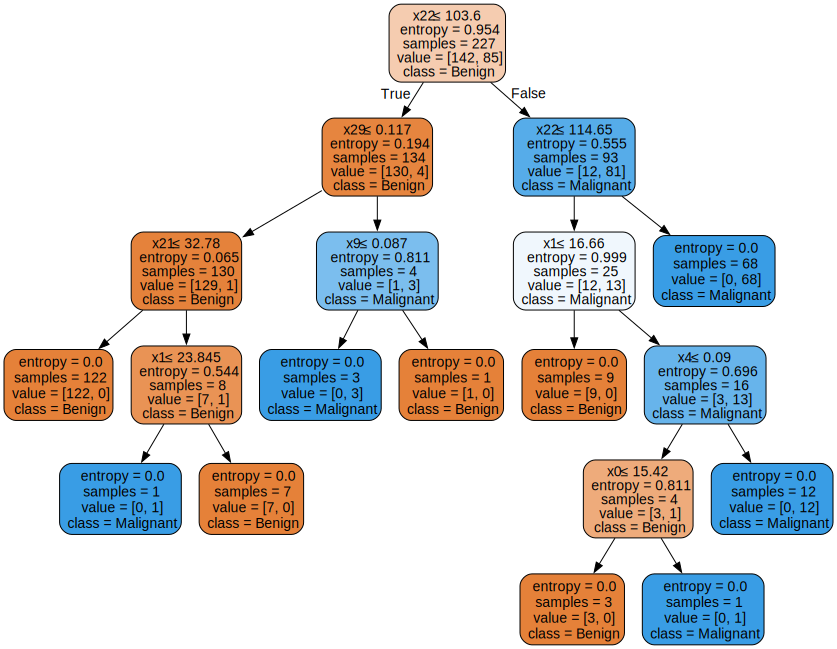

Cây quyết định với tỷ lệ 40_60 lưu vào Dataset 1/split_ratios_graphviz\graph_model_40_60.png



(process:6840): Pango-CRITICAL **: 18:49:23.540: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:6840): Pango-CRITICAL **: 18:49:23.541: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:6840): Pango-CRITICAL **: 18:49:23.541: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:6840): Pango-CRITICAL **: 18:49:23.541: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16156): Pango-CRITICAL **: 18:49:25.038: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16156): Pango-CRITICAL **: 18:49:25.038: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16156): Pango-CRITICAL **: 18:49:25.038: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16156): Pango-CRITICAL **: 18:49:25.038: pango_font_description_get_family: assertion 'desc != NULL' failed


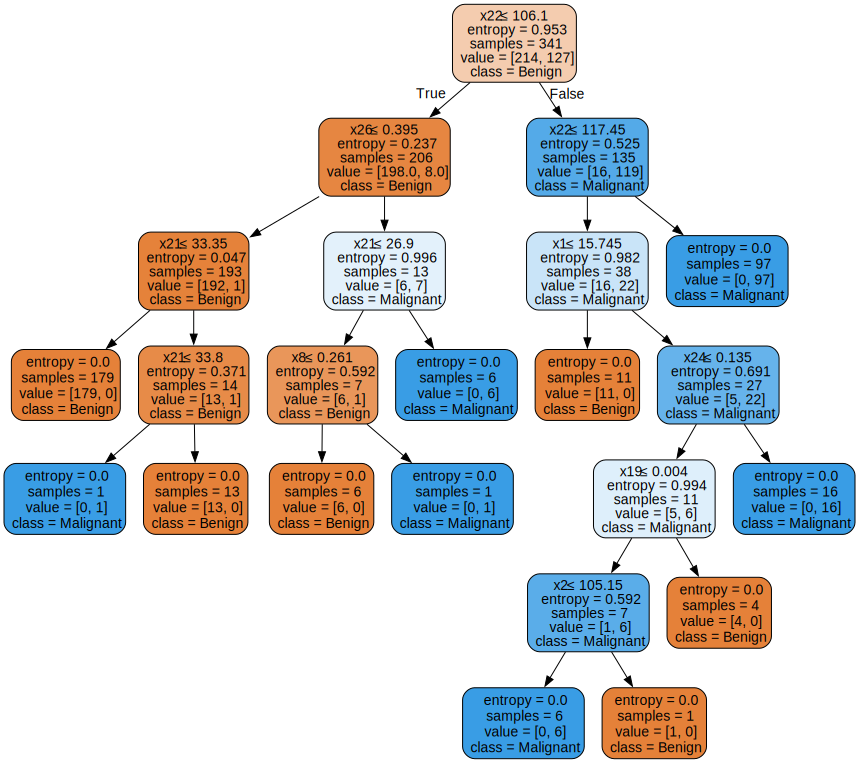

Cây quyết định với tỷ lệ 60_40 lưu vào Dataset 1/split_ratios_graphviz\graph_model_60_40.png



(process:16364): Pango-CRITICAL **: 18:49:26.532: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16364): Pango-CRITICAL **: 18:49:26.532: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16364): Pango-CRITICAL **: 18:49:26.532: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16364): Pango-CRITICAL **: 18:49:26.532: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:5640): Pango-CRITICAL **: 18:49:28.296: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:5640): Pango-CRITICAL **: 18:49:28.296: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:5640): Pango-CRITICAL **: 18:49:28.296: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:5640): Pango-CRITICAL **: 18:49:28.296: pango_font_description_get_family: assertion 'desc != NULL' failed


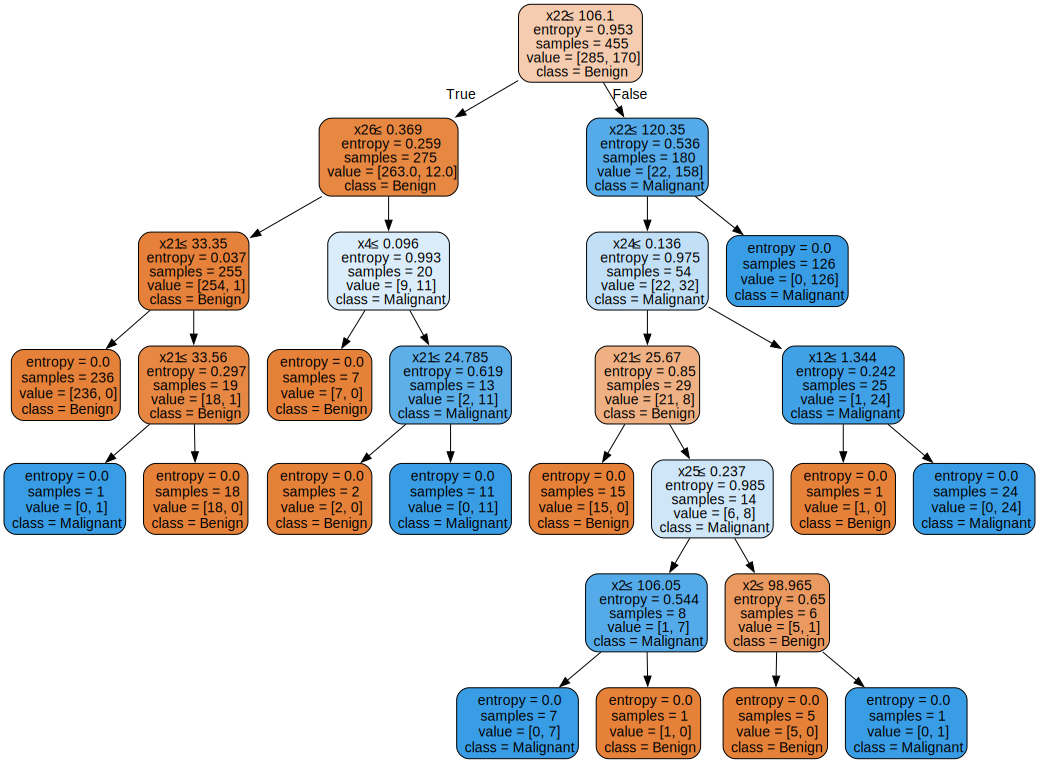

Cây quyết định với tỷ lệ 80_20 lưu vào Dataset 1/split_ratios_graphviz\graph_model_80_20.png



(process:7332): Pango-CRITICAL **: 18:49:30.247: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7332): Pango-CRITICAL **: 18:49:30.247: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7332): Pango-CRITICAL **: 18:49:30.247: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7332): Pango-CRITICAL **: 18:49:30.247: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16532): Pango-CRITICAL **: 18:49:32.515: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16532): Pango-CRITICAL **: 18:49:32.515: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16532): Pango-CRITICAL **: 18:49:32.515: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16532): Pango-CRITICAL **: 18:49:32.517: pango_font_description_get_family: assertion 'desc != NULL' failed


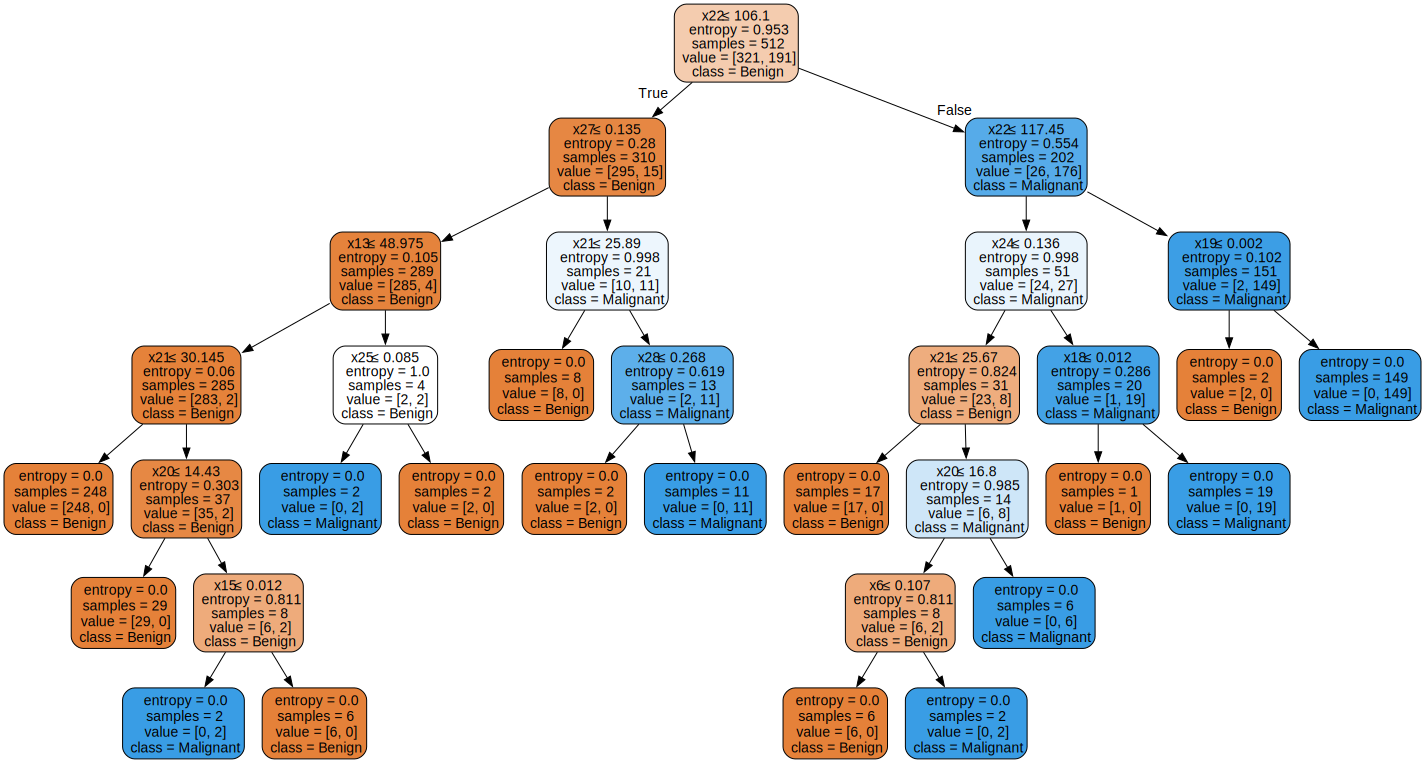

Cây quyết định với tỷ lệ 90_10 lưu vào Dataset 1/split_ratios_graphviz\graph_model_90_10.png


In [13]:
def visualize_decision_tree(list_models, split_ratios, feature_name, class_name, output_dir="Dataset 1/split_ratios_graphviz"):
    os.makedirs(output_dir, exist_ok=True)

    for model, (train_size, test_size) in zip(list_models, split_ratios):
        ratio = f"{int(train_size * 100)}_{int(test_size * 100)}"
        model_filename = os.path.join(output_dir, f"graph_model_{ratio}")

        try:
            dot_data = export_graphviz(
                model, feature_names=feature_name, class_names=class_name,
                filled=True, rounded=True, special_characters=True
            )

            graph = graphviz.Source(dot_data, engine="dot")
            graph.render(model_filename, format="png", cleanup=True)
            display(graph)
            print(f"Cây quyết định với tỷ lệ {ratio} lưu vào {model_filename}.png")

        except Exception as e:
            print(f"Lỗi hiển thị {ratio}: {e}")

# Gọi hàm
class_name = ["Benign", "Malignant"]
visualize_decision_tree(list_models, split_ratios, features_name, class_name)

## 3. Evaluating the Decision Tree Classifiers

### 3.1 Visualize the Confusion Matrix and Classification Report

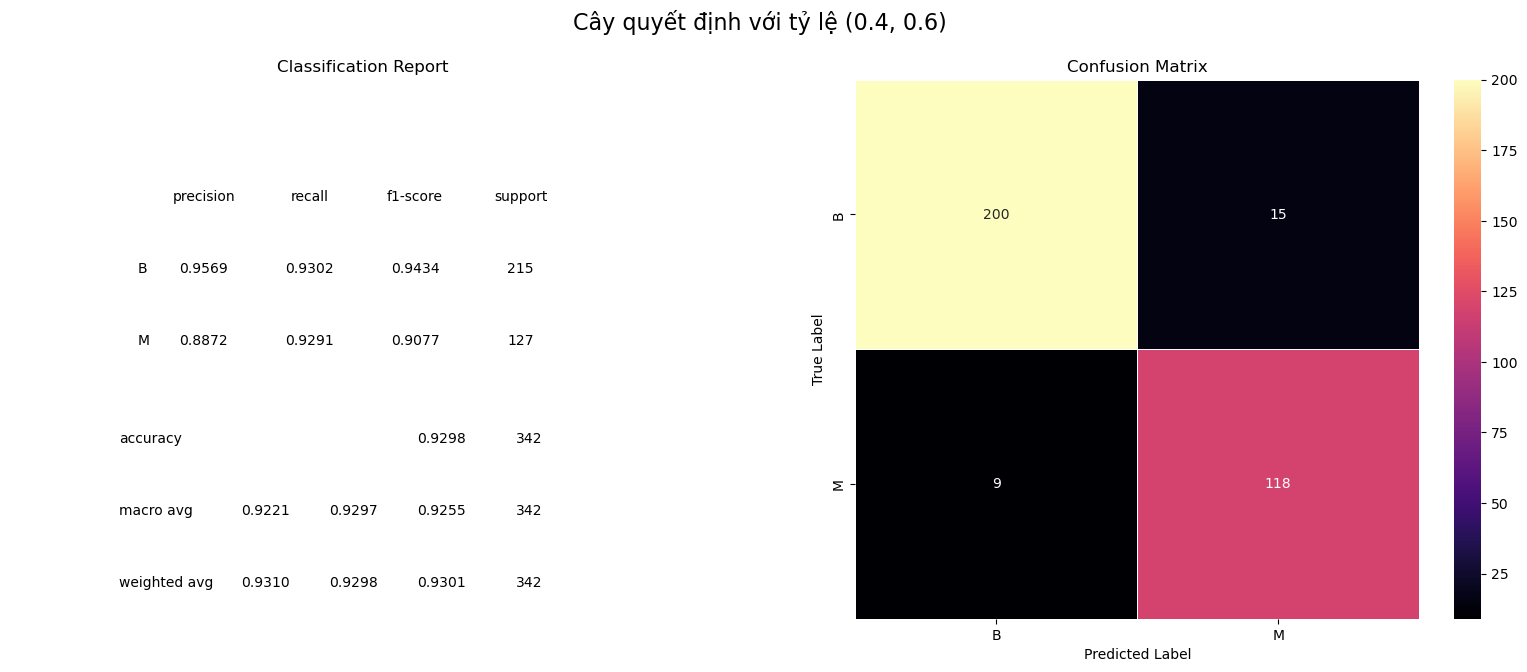

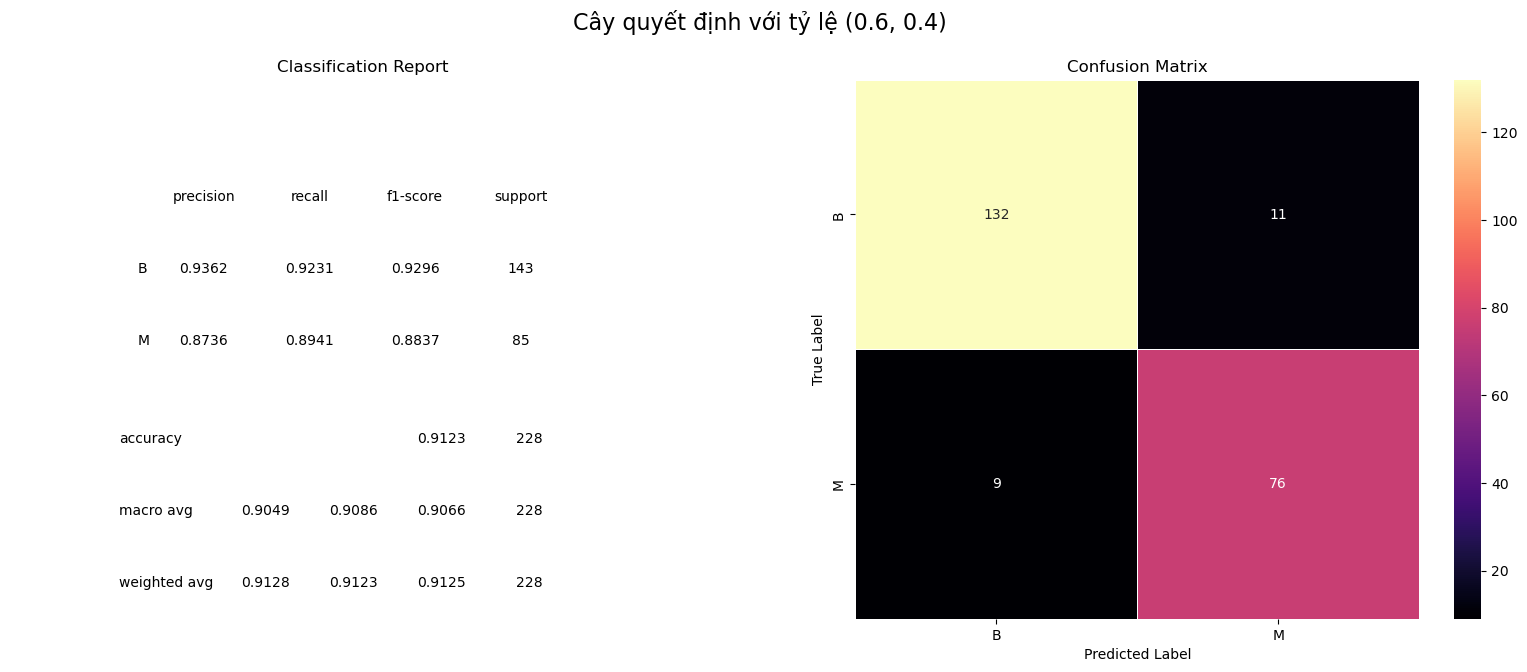

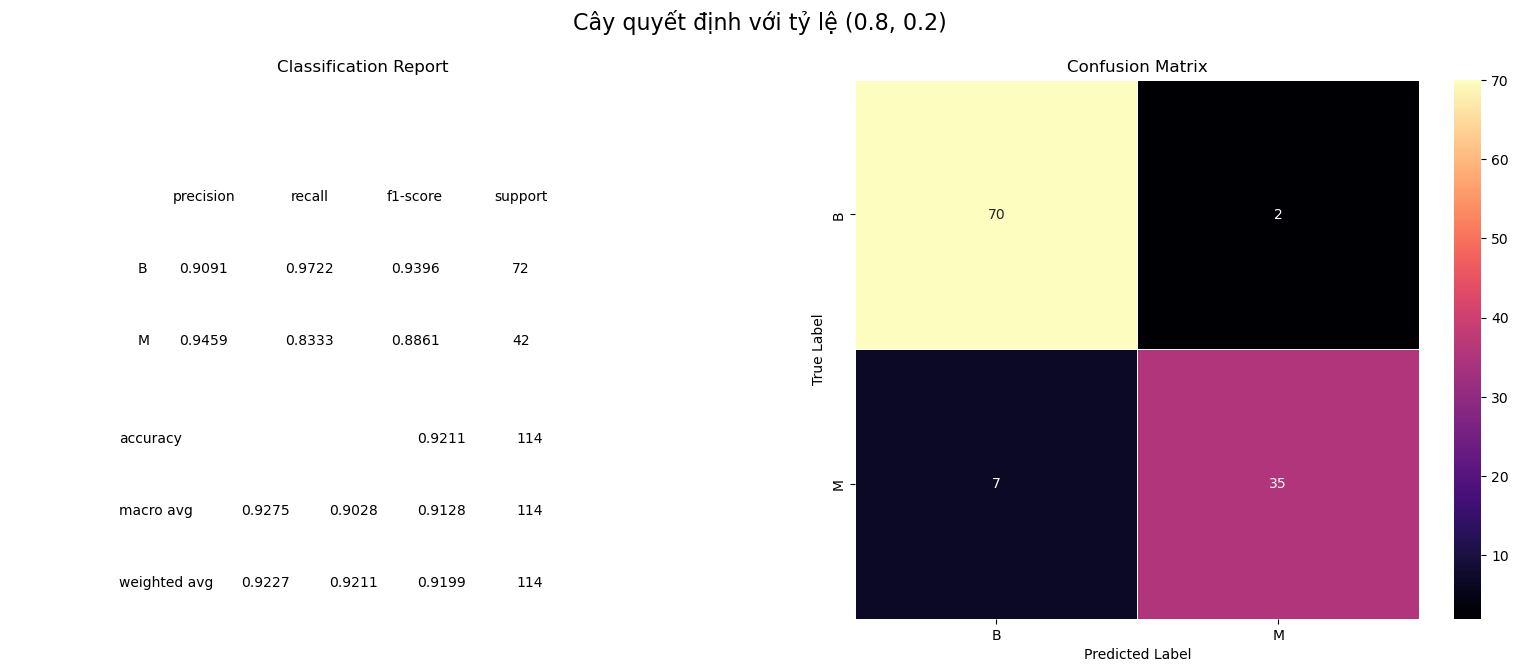

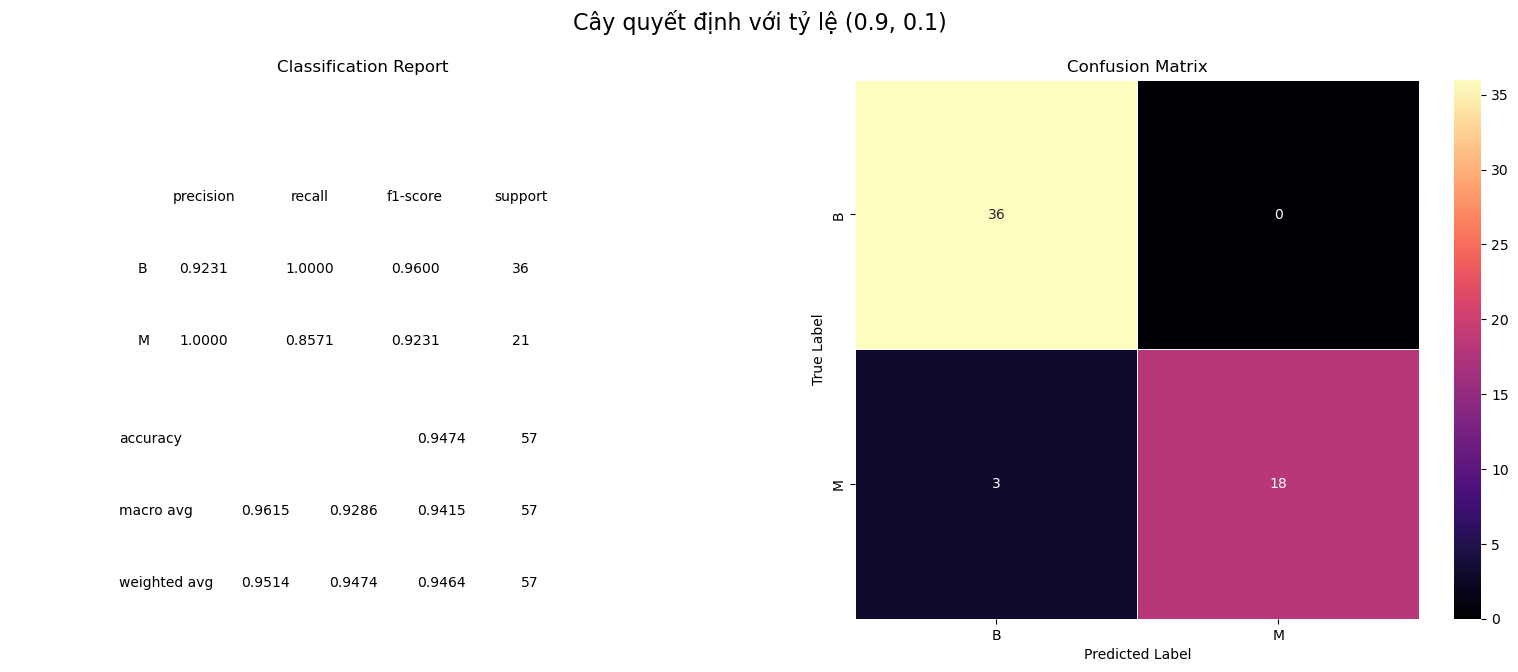

In [14]:
def plot_classification_report(data, class_labels, stats):
    """
    Vẽ bảng báo cáo phân loại.
    """
    plt.axis("off")
    table = plt.table(cellText=data, colLabels=["precision", "recall", "f1-score", "support"], 
                      rowLabels=class_labels, loc="center", cellLoc="center", bbox=[0.2, 0.45, 0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    for cell in table.get_celld().values():
        cell.set_edgecolor("white")

    stats_table = plt.table(cellText=stats, rowLabels=["accuracy", "macro avg", "weighted avg"], 
                            loc="lower center", cellLoc="center", bbox=[0.3, 0, 0.5, 0.4])
    stats_table.auto_set_font_size(False)
    stats_table.set_fontsize(10)
    for cell in stats_table.get_celld().values():
        cell.set_edgecolor("white")

    plt.title("Classification Report")

def plot_confusion_matrix(matrix, labels):
    """
    Vẽ heatmap cho ma trận nhầm lẫn.
    """
    sns.heatmap(matrix, annot=True, cmap="magma", fmt="d", cbar=True, 
                xticklabels=labels, yticklabels=labels, linewidths=0.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

def evaluating_models(list_models, datasets, split_ratios, output_dir="Dataset 1/reports/evaluating_models", show_plot=True):
    os.makedirs(output_dir, exist_ok=True)

    for model, (feature_train, feature_test, label_train, label_test), proportion in zip(list_models, datasets, split_ratios):
        # Dự đoán và tạo báo cáo
        label_prediction = model.predict(feature_test)
        report = classification_report(label_test, label_prediction, zero_division=1, digits=4)
        matrix = confusion_matrix(label_test, label_prediction)

        # Trích xuất thông tin từ báo cáo
        lines = report.strip().split("\n")
        class_labels = [line.split()[0] for line in lines[2:-4]]
        data = [line.split()[1:] for line in lines[2:-4]]
        stats = [
            [" ", " "] + lines[-3].split()[1:],  # accuracy
            lines[-2].split()[2:],  # macro avg
            lines[-1].split()[2:]   # weighted avg
        ]

        # Bắt đầu vẽ biểu đồ
        plt.figure(figsize=(20, 7))

        # Báo cáo phân loại
        plt.subplot(1, 2, 1)
        plot_classification_report(data, class_labels, stats)

        # Ma trận nhầm lẫn
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(matrix, labels=model.classes_)

        # Tiêu đề tổng quát và lưu hình ảnh
        model_name = model.__class__.__name__
        plt.suptitle(f"Cây quyết định với tỷ lệ {proportion}", fontsize=16)

        file_name = f"{model_name}_report_{int(proportion[0]*100)}_{int(proportion[1]*100)}.png"
        file_path = os.path.join(output_dir, file_name)
        plt.savefig(file_path)
        if show_plot:
            plt.show()
        plt.close()


# Gọi hàm
evaluating_models(list_models, datasets, split_ratios)

## 4. The Depth and Accuracy of a Decision Tree

### 4.1 Train the Model with a Maximum Depth for the Decision Tree

In [15]:
# Chiều sâu cần kiểm tra
list_max_depth = [2, 3, 4, 5, 6, 7, None]

In [16]:
def max_depth_model_decision_tree(datasets, list_max_depth):
    feature_train, feature_test, label_train, label_test = datasets[2]
    os.makedirs("Dataset 1/models/model_max_depth_decision_tree", exist_ok=True)

    models, accuracy_results = [], {}
    for max_depth in list_max_depth:
        model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
        model.fit(feature_train, label_train)
        accuracy_results[max_depth] = accuracy_score(label_test, model.predict(feature_test))
        joblib.dump(model, f"Dataset 1/models/model_max_depth_decision_tree/model_dt_depth_{max_depth}.pkl")
        models.append(model)

    return models, accuracy_results

# Gọi hàm
list_max_depth_model, accuracy_results = max_depth_model_decision_tree(datasets, list_max_depth)

### 4.2 Visualize Decision Trees for Different Max Depth Values


(process:6544): Pango-CRITICAL **: 18:49:41.193: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:6544): Pango-CRITICAL **: 18:49:41.193: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:6544): Pango-CRITICAL **: 18:49:41.197: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:6544): Pango-CRITICAL **: 18:49:41.197: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15068): Pango-CRITICAL **: 18:49:42.374: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15068): Pango-CRITICAL **: 18:49:42.374: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15068): Pango-CRITICAL **: 18:49:42.374: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15068): Pango-CRITICAL **: 18:49:42.374: pango_font_description_get_family: assertion 'desc != NULL' failed


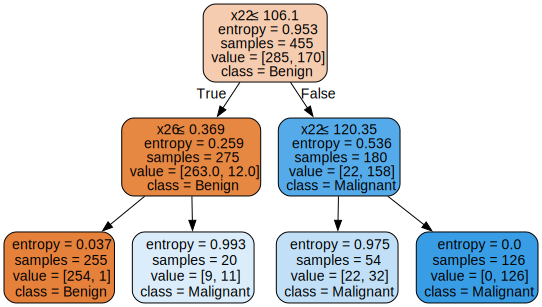

Graph saved: Dataset 1/max_depth_graphviz\graph_model_80_20_depth_2.png (max_depth=2)



(process:8768): Pango-CRITICAL **: 18:49:43.610: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:8768): Pango-CRITICAL **: 18:49:43.610: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:8768): Pango-CRITICAL **: 18:49:43.610: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:8768): Pango-CRITICAL **: 18:49:43.610: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13740): Pango-CRITICAL **: 18:49:44.891: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13740): Pango-CRITICAL **: 18:49:44.891: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13740): Pango-CRITICAL **: 18:49:44.891: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13740): Pango-CRITICAL **: 18:49:44.891: pango_font_description_get_family: assertion 'desc != NULL' failed


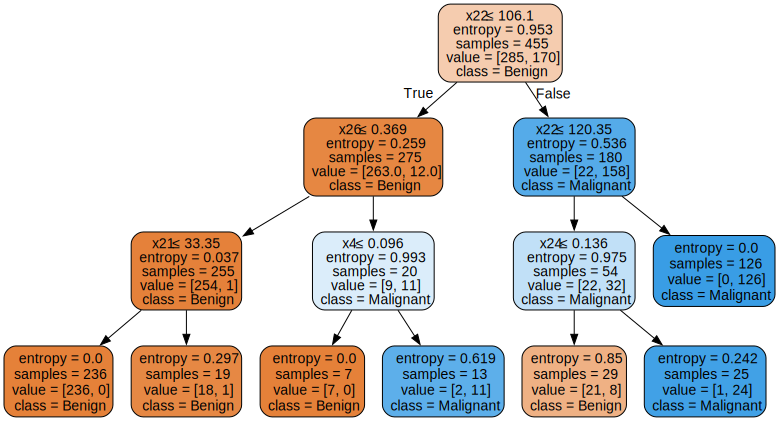

Graph saved: Dataset 1/max_depth_graphviz\graph_model_80_20_depth_3.png (max_depth=3)



(process:14228): Pango-CRITICAL **: 18:49:45.937: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14228): Pango-CRITICAL **: 18:49:45.937: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14228): Pango-CRITICAL **: 18:49:45.937: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14228): Pango-CRITICAL **: 18:49:45.939: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13476): Pango-CRITICAL **: 18:49:47.177: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13476): Pango-CRITICAL **: 18:49:47.177: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13476): Pango-CRITICAL **: 18:49:47.177: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13476): Pango-CRITICAL **: 18:49:47.177: pango_font_description_get_family: assertion 'desc != NULL' failed


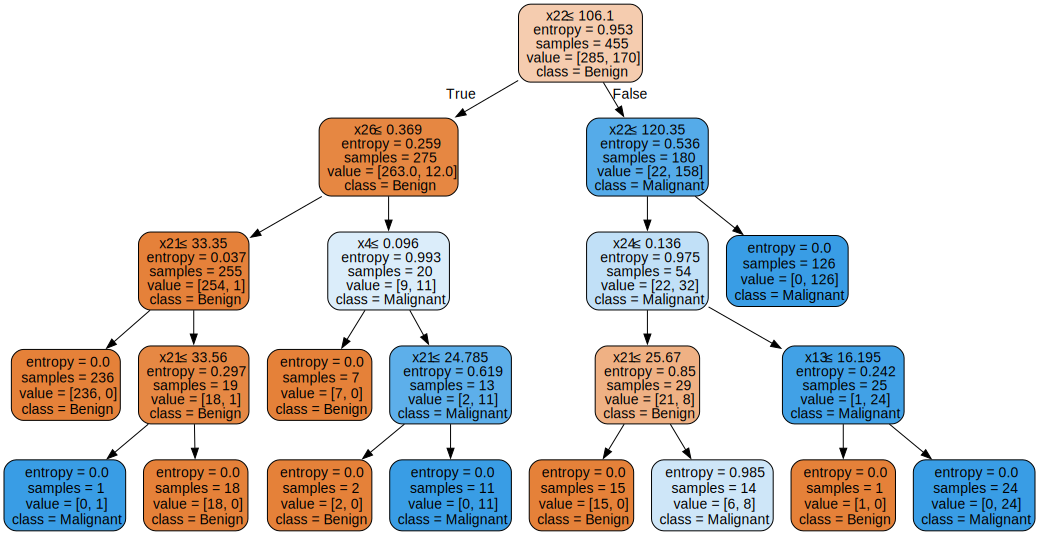

Graph saved: Dataset 1/max_depth_graphviz\graph_model_80_20_depth_4.png (max_depth=4)



(process:16852): Pango-CRITICAL **: 18:49:48.217: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16852): Pango-CRITICAL **: 18:49:48.218: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16852): Pango-CRITICAL **: 18:49:48.218: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16852): Pango-CRITICAL **: 18:49:48.218: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1192): Pango-CRITICAL **: 18:49:49.579: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1192): Pango-CRITICAL **: 18:49:49.582: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1192): Pango-CRITICAL **: 18:49:49.582: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1192): Pango-CRITICAL **: 18:49:49.582: pango_font_description_get_family: assertion 'desc != NULL' failed


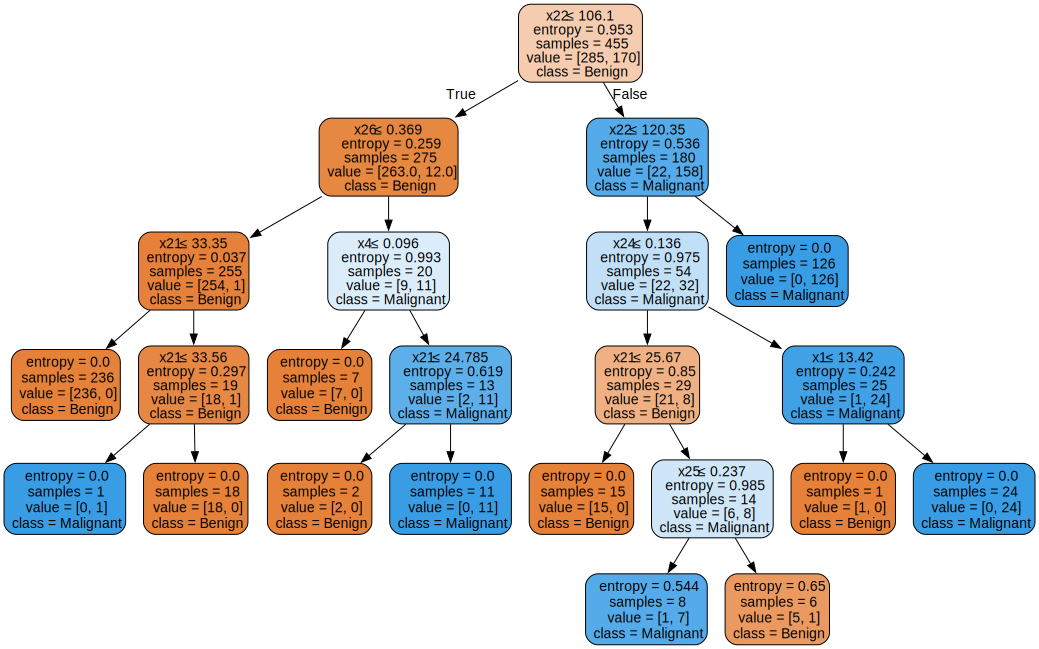

Graph saved: Dataset 1/max_depth_graphviz\graph_model_80_20_depth_5.png (max_depth=5)



(process:15784): Pango-CRITICAL **: 18:49:50.661: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15784): Pango-CRITICAL **: 18:49:50.661: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15784): Pango-CRITICAL **: 18:49:50.661: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15784): Pango-CRITICAL **: 18:49:50.661: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:3924): Pango-CRITICAL **: 18:49:51.951: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:3924): Pango-CRITICAL **: 18:49:51.951: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:3924): Pango-CRITICAL **: 18:49:51.951: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:3924): Pango-CRITICAL **: 18:49:51.951: pango_font_description_get_family: assertion 'desc != NULL' failed


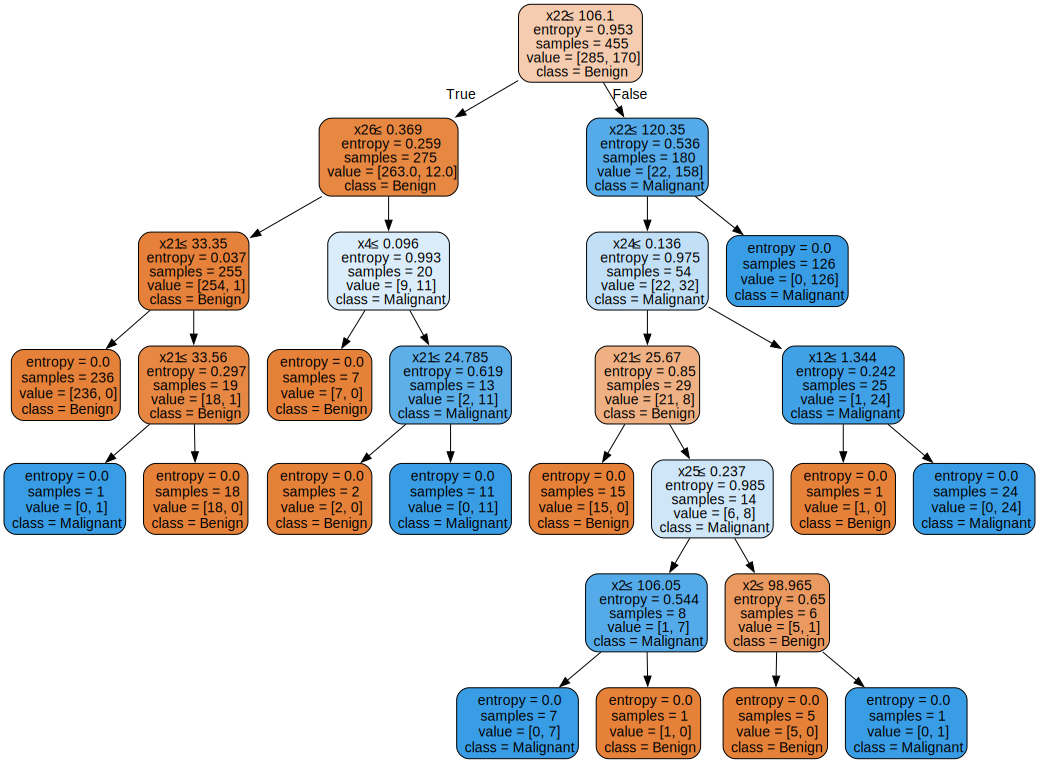

Graph saved: Dataset 1/max_depth_graphviz\graph_model_80_20_depth_6.png (max_depth=6)



(process:15436): Pango-CRITICAL **: 18:49:53.161: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15436): Pango-CRITICAL **: 18:49:53.162: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15436): Pango-CRITICAL **: 18:49:53.162: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15436): Pango-CRITICAL **: 18:49:53.162: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13936): Pango-CRITICAL **: 18:49:54.628: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13936): Pango-CRITICAL **: 18:49:54.629: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13936): Pango-CRITICAL **: 18:49:54.629: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13936): Pango-CRITICAL **: 18:49:54.629: pango_font_description_get_family: assertion 'desc != NULL' failed


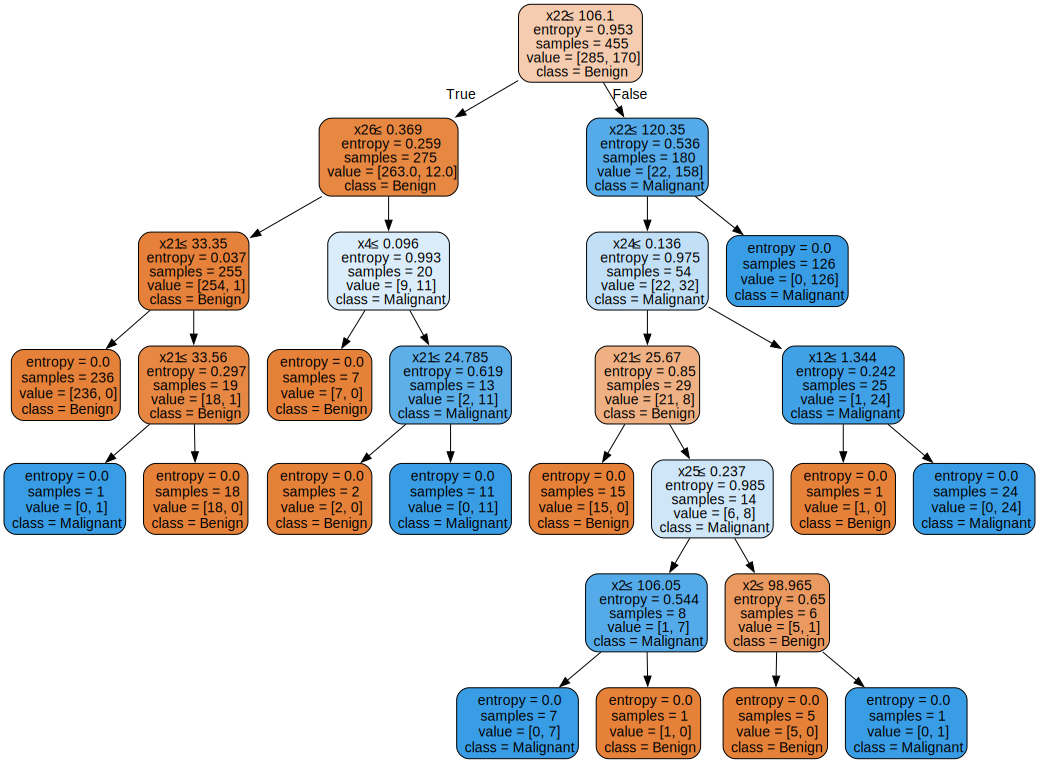

Graph saved: Dataset 1/max_depth_graphviz\graph_model_80_20_depth_7.png (max_depth=7)



(process:12536): Pango-CRITICAL **: 18:49:56.005: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12536): Pango-CRITICAL **: 18:49:56.005: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12536): Pango-CRITICAL **: 18:49:56.006: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12536): Pango-CRITICAL **: 18:49:56.006: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15568): Pango-CRITICAL **: 18:49:57.351: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15568): Pango-CRITICAL **: 18:49:57.351: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15568): Pango-CRITICAL **: 18:49:57.351: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15568): Pango-CRITICAL **: 18:49:57.351: pango_font_description_get_family: assertion 'desc != NULL' failed


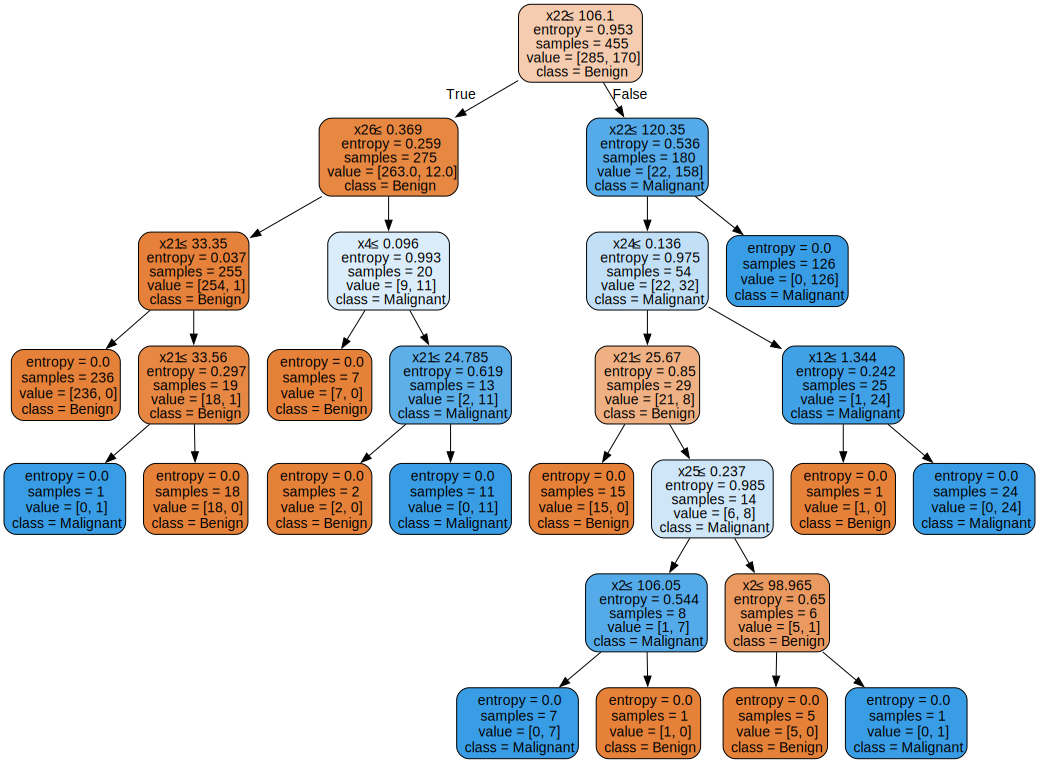

Graph saved: Dataset 1/max_depth_graphviz\graph_model_80_20_depth_None.png (max_depth=None)


In [17]:
def visualize_max_depth(models, depths, features, classes):
    output_dir = "Dataset 1/max_depth_graphviz"
    os.makedirs(output_dir, exist_ok=True)

    for model, depth in zip(models, depths):
        # Export model to Graphviz format
        graph = graphviz.Source(export_graphviz(
            model, feature_names=features, class_names=classes,
            filled=True, rounded=True, special_characters=True
        ))
        # Render and save as PNG
        filename = os.path.join(output_dir, f"graph_model_80_20_depth_{depth}")
        graph.render(filename, format="png", cleanup=True)
        display(graph)  # Display graph inline
        print(f"Graph saved: {filename}.png (max_depth={depth})")

# gọi hàm
visualize_max_depth(list_max_depth_model, list_max_depth, features_name, class_name)

### 4.3 Report of decision tree when changing the value of parameter `max_depth`

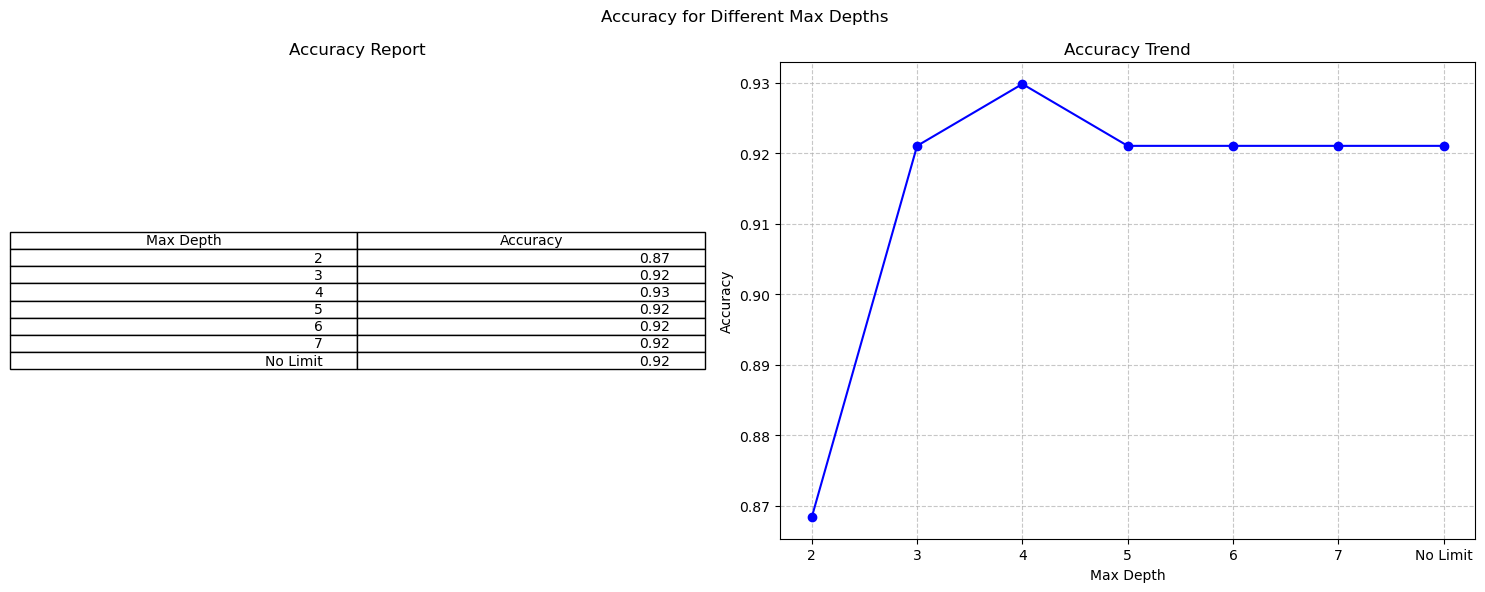

In [18]:
def plot_max_depth_accuracy(accuracy_results, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    max_depths = ["No Limit" if d is None else str(d) for d in accuracy_results.keys()]
    accuracies = list(accuracy_results.values())
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.table(cellText=[[d, f"{a:.2f}"] for d, a in zip(max_depths, accuracies)], colLabels=["Max Depth", "Accuracy"], loc="center")
    plt.axis("off")
    plt.title("Accuracy Report")

    plt.subplot(1, 2, 2)
    plt.plot(max_depths, accuracies, marker="o", color="blue")
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Trend")
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.suptitle("Accuracy for Different Max Depths")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Gọi hàm
output_path = f"Dataset 1/reports/max_depth_accuracy/accuracy_report.png"
plot_max_depth_accuracy(accuracy_results, output_path)